# Analysis of eeg's files

- Missing values.
- numpy file with indices of eegs with less than 3 NaN in train.csv
- Saturated eegs (values 9999.0)
- Counting votes inside an eeg.
- Overlapping: there are changes in votes in some cases. 
- Different combinations of percentages: possible classes.
- Extracting eeg_id with unanimous consensus in complete eegs. Balanced?

In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# base_dir = "../../kaggle_data/hms"
base_dir = "../../data/hms"
# base_dir = "/kaggle/input/hms-harmful-brain-activity-classification"


In [2]:
len(os.listdir(f'{base_dir}/train_eegs'))


17300

In [3]:
fs = 200  # Sample rate.

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
print(df_traincsv.shape)
df_traincsv.head()

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
eeg_ids = df_traincsv.eeg_id.unique()
len(eeg_ids)


17089

## Missing values?

Find NaN in each 10 s sub eeg and 50 s sub eeg.

In [5]:
# Example of counting rows with NaN values.

eeg_id = 443031384
eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# pd.isna(eeg).any(axis=None)
display(eeg.loc[pd.isna(eeg).any(axis=1)])
print(len(eeg.loc[pd.isna(eeg).any(axis=1)]), "rows")

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
4330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2 rows


In [6]:
# This takes 2 min 40 s in framework.

eeg_ids = df_traincsv['eeg_id'].unique()
print("Number of eeg_ids:", len(eeg_ids))

# Output: ../data/02_df_nans_in_sub_eegs.csv
# Pandas dataframe:
# idx : index in train.csv
# eeg_id
# eeg_sub_id
# nan_rows_10 : number of rows with NaN values in the central 10 seconds.
# nan_rows_50 : number of rows with NaN values in 50 seconds sub eeg.

idxs = []
ids = []
sub_ids = []
nan_rows_10 = []
nan_rows_50 = []
for n, eeg_id in enumerate(eeg_ids):
    if n%500 == 0:
        print(f'Loaded {n} files.', end='\r')

    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
    items = df_traincsv.loc[df_traincsv.eeg_id == eeg_id]
    n = len(items)
    for i in np.arange(n):
        item = items.iloc[i]
        offset = int(item.eeg_label_offset_seconds)
        # 10 second eeg sub sample 
        start = (offset + 20) * fs
        end = (offset + 30) * fs
        eeg_sub_10 = eeg[start:end]
        # 50 second eeg sub sample 
        start = offset * fs
        end = (offset + 50) * fs
        eeg_sub_50 = eeg[start:end]
        idxs.append(item.name)
        ids.append(eeg_id)
        sub_ids.append(item.eeg_sub_id)
        nan_rows_10.append(pd.isna(eeg_sub_10).any(axis=1).sum())
        nan_rows_50.append(pd.isna(eeg_sub_50).any(axis=1).sum())
print('Done.                 ')

d = {
    'idx'    : idxs,
    'eeg_id' : ids,
    'eeg_sub_id' : sub_ids,
    'nan_rows_10' : nan_rows_10,
    'nan_rows_50' : nan_rows_50,
}
df_nans = pd.DataFrame(data=d)
df_nans.to_csv("../data/02_df_nans_in_sub_eegs.csv", index=False)

Number of eeg_ids: 17089
Done.                 


In [7]:
df_nans = pd.read_csv("../data/02_df_nans_in_sub_eegs.csv")
df_nans

,idx,eeg_id,eeg_sub_id,nan_rows_10,nan_rows_50
0,0,1628180742,0,0,0
1,1,1628180742,1,0,0
2,2,1628180742,2,0,0
3,3,1628180742,3,0,0
4,4,1628180742,4,0,0
...,...,...,...,...,...
106795,106795,351917269,6,0,0
106796,106796,351917269,7,0,0
106797,106797,351917269,8,0,0
106798,106798,351917269,9,0,0


In [8]:
df_nans.loc[df_nans.nan_rows_10 > 0]

,idx,eeg_id,eeg_sub_id,nan_rows_10,nan_rows_50
205,205,3630961636,0,1,1
232,232,443031384,0,1,2
235,235,443031384,3,1,1
257,257,3780058941,9,400,4400
258,258,3780058941,10,800,4800
...,...,...,...,...,...
106749,106749,3813274317,8,1,1
106750,106750,3813274317,9,1,1
106751,106751,3813274317,10,1,1
106752,106752,3813274317,11,1,1


<div class="alert alert-block alert-info"> <b>NOTE:</b> Only 727 sub eegs of 10 s have NaN rows.</div>

{'whiskers': [<matplotlib.lines.Line2D at 0x7a9ffae21880>,
 'caps': [<matplotlib.lines.Line2D at 0x7a9ffae20fe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a9ffaf9e930>],
 'medians': [<matplotlib.lines.Line2D at 0x7aa000015bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a9ffae21340>],
 'means': []}

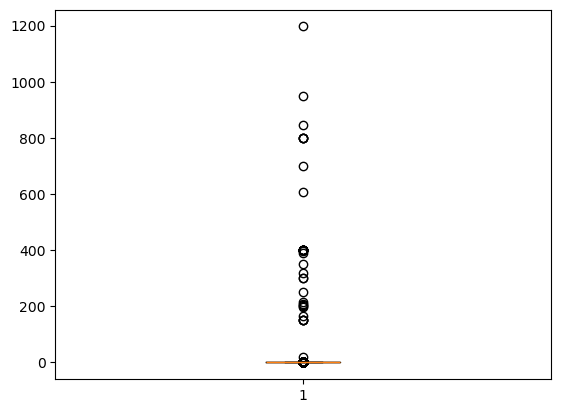

In [28]:
plt.boxplot(df_nans.nan_rows_10)

In [29]:
len(df_nans.loc[df_nans.nan_rows_10 > 2])


39

<div class="alert alert-block alert-info"> <b>NOTE:</b> Only 39 sub eegs of 10 s have more than 2 NaN rows.</div>


In [30]:
df_nans.loc[df_nans.nan_rows_50 > 0]


,idx,eeg_id,eeg_sub_id,nan_rows_10,nan_rows_50
205,205,3630961636,0,1,1
206,206,3630961636,1,0,1
207,207,3630961636,2,0,1
232,232,443031384,0,1,2
233,233,443031384,1,0,2
...,...,...,...,...,...
106756,106756,3813274317,15,0,1
106757,106757,3813274317,16,0,1
106758,106758,3813274317,17,0,1
106759,106759,3813274317,18,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x7a9ffaeb5640>,
 'caps': [<matplotlib.lines.Line2D at 0x7a9ffaeb5c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a9ffaeb5430>],
 'medians': [<matplotlib.lines.Line2D at 0x7a9ffaeb6210>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a9ffaeb6600>],
 'means': []}

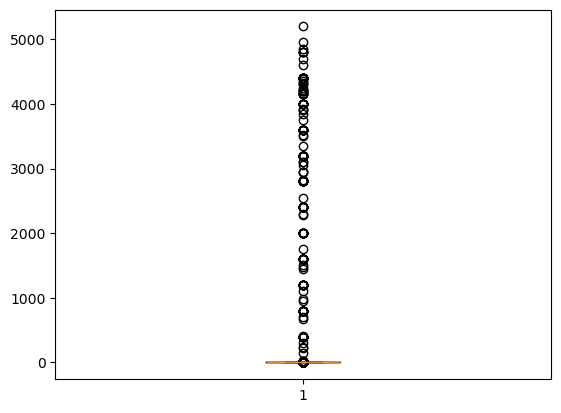

In [31]:
plt.boxplot(df_nans.nan_rows_50)

In [32]:
df_nans.loc[df_nans.nan_rows_50 > 2].sort_values(by='nan_rows_50')

,idx,eeg_id,eeg_sub_id,nan_rows_10,nan_rows_50
42330,42330,2694902665,1,2,3
28076,28076,218040948,6,0,3
28077,28077,218040948,7,0,3
28078,28078,218040948,8,1,3
68029,68029,4101218189,10,1,3
...,...,...,...,...,...
258,258,3780058941,10,800,4800
57304,57304,975631111,0,800,4800
83695,83695,1593385762,0,847,4847
74718,74718,3931449367,0,950,4950


<div class="alert alert-block alert-info"> <b>NOTE:</b> Only 244 sub eegs of 50 s have more than 2 NaN rows. Discarding these.</div>

In [9]:
idxs_less_nans = df_nans.loc[df_nans.nan_rows_50 < 3]['idx'].values
print("Observations (50 s) with less than 3 NaN rows:", len(idxs_less_nans))

Observations (50 s) with less than 3 NaN rows: 106556


In [10]:
np.save("../data/02_eegs_sub_50_idxs_less_3_nan.npy",idxs_less_nans)  # Indices in train.csv

How to load and interpolate:

In [6]:
idxs = np.load("../data/02_eegs_sub_50_idxs_less_3_nan.npy")
df_traincsv.loc[idxs]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [8]:
eeg_id = 443031384
eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
idxs_nans = eeg[pd.isna(eeg).any(axis=1)].index
print('Before interpolation:')
for idx in idxs_nans:
    display(eeg.iloc[(idx-2):(idx+3)])
print("After interpolation:")
eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation
for idx in idxs_nans:
    display(eeg.iloc[(idx-2):(idx+3)])


Before interpolation:


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
4328,-9.84,9.300000,-22.60,-35.889999,-35.889999,-62.470001,-28.709999,-48.380001,-5.58,-37.220001,-40.939999,-17.549999,-32.959999,-9.84,-39.610001,8.77,-46.790001,-47.849998,-59.810001,33.490002
4329,22.60,14.090000,5.32,-13.820000,-9.840000,-36.950001,-6.380000,-28.980000,13.56,-23.930000,-24.459999,6.380000,-18.610001,1.06,-28.180000,19.41,-34.029999,-31.629999,-42.529999,43.860001
4330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4331,5.85,6.650000,-12.49,-35.360001,-16.750000,-48.119999,-22.600000,-54.500000,2.92,-39.880001,-49.709999,-9.570000,-37.480000,-19.67,-49.980000,6.91,-49.450001,-52.099998,-65.660004,25.520000
4332,19.67,33.759998,-3.99,-29.510000,-7.710000,-41.470001,-15.680000,-48.380001,8.77,-37.480000,-47.590000,-3.990000,-30.309999,-14.09,-42.799999,17.01,-39.880001,-42.000000,-58.220001,37.209999


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
9296,38.279999,11.17,16.219999,3.19,12.230000,-26.049999,-0.530000,18.080000,21.270000,-3.46,1.86,26.320000,-7.18,20.740000,6.91,41.200001,-6.91,-2.66,1.86,47.590000
9297,42.270000,-12.23,22.330000,6.65,21.270000,-16.750000,6.380000,21.799999,28.180000,0.53,7.98,40.669998,0.27,28.709999,9.84,49.980000,1.06,3.46,7.71,42.799999
9298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9299,32.959999,25.25,19.139999,4.79,13.290000,-20.200001,3.990000,9.570000,12.230000,-10.90,-4.79,12.230000,-18.08,11.430000,-1.86,35.090000,-13.82,-11.96,-7.98,47.049999
9300,48.910000,-10.63,36.150002,15.15,30.309999,-2.660000,17.809999,21.000000,27.379999,2.13,8.77,41.740002,0.00,27.120001,5.05,49.980000,3.19,3.72,5.85,47.049999


After interpolation:


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
4328,-9.840,9.300000,-22.600,-35.889999,-35.889999,-62.470001,-28.709999,-48.380001,-5.58,-37.220001,-40.939999,-17.549999,-32.959999,-9.840,-39.610001,8.77,-46.790001,-47.849998,-59.810001,33.490002
4329,22.600,14.090000,5.320,-13.820000,-9.840000,-36.950001,-6.380000,-28.980000,13.56,-23.930000,-24.459999,6.380000,-18.610001,1.060,-28.180000,19.41,-34.029999,-31.629999,-42.529999,43.860001
4330,14.225,10.370000,-3.585,-24.590000,-13.295000,-42.535000,-14.490000,-41.739998,8.24,-31.905001,-37.084999,-1.595000,-28.045000,-9.305,-39.080002,13.16,-41.739998,-41.864998,-54.095001,34.690002
4331,5.850,6.650000,-12.490,-35.360001,-16.750000,-48.119999,-22.600000,-54.500000,2.92,-39.880001,-49.709999,-9.570000,-37.480000,-19.670,-49.980000,6.91,-49.450001,-52.099998,-65.660004,25.520000
4332,19.670,33.759998,-3.990,-29.510000,-7.710000,-41.470001,-15.680000,-48.380001,8.77,-37.480000,-47.590000,-3.990000,-30.309999,-14.090,-42.799999,17.01,-39.880001,-42.000000,-58.220001,37.209999


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
9296,38.279999,11.17,16.219999,3.19,12.230000,-26.049999,-0.530000,18.080000,21.270000,-3.460,1.860,26.320000,-7.180,20.740000,6.91,41.200001,-6.91,-2.66,1.860,47.590000
9297,42.270000,-12.23,22.330000,6.65,21.270000,-16.750000,6.380000,21.799999,28.180000,0.530,7.980,40.669998,0.270,28.709999,9.84,49.980000,1.06,3.46,7.710,42.799999
9298,37.614998,6.51,20.735001,5.72,17.280001,-18.475000,5.185000,15.684999,20.205000,-5.185,1.595,26.449999,-8.905,20.070000,3.99,42.535000,-6.38,-4.25,-0.135,44.924999
9299,32.959999,25.25,19.139999,4.79,13.290000,-20.200001,3.990000,9.570000,12.230000,-10.900,-4.790,12.230000,-18.080,11.430000,-1.86,35.090000,-13.82,-11.96,-7.980,47.049999
9300,48.910000,-10.63,36.150002,15.15,30.309999,-2.660000,17.809999,21.000000,27.379999,2.130,8.770,41.740002,0.000,27.120001,5.05,49.980000,3.19,3.72,5.850,47.049999


## Saturation or malfunctions in sub eegs

Some eegs have values 9999.0. How many in each sub eeg?

In [22]:
# Removing observations where eeg has more than 2 NaN rows.
idxs = np.load("../data/02_eegs_sub_50_idxs_less_3_nan.npy")
df = df_traincsv.loc[idxs]

eeg_ids = df['eeg_id'].unique()

In [10]:
# Example of malfunction:

eeg_id = 493696785
eeg_sub_id = 3  # seizure
# eeg_id = 1029863597
# eeg_sub_id = 15  # seizure
# eeg_id = 3988090520
# eeg_sub_id = 1

eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')

eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
1,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
2,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
3,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0
4,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0


In [7]:
# Example of counting 9999.0
eeg.map(lambda x: x == 9999.0).sum().sum()/(eeg.shape[0]*eeg.shape[1])

0.06409567901234568

6.4% of this eeg is saturated.

Count 9999.0 in each sub eeg.

In [16]:
# # This takes 31 min in framework.

# # Output: ../data/02_df_9999.csv
# # Pandas dataframe:
# # idx : index in train.csv (after filtering more than 2 NaN rows)
# # eeg_id
# # eeg_sub_id
# # percentage_9999_50 : percentage of cells with 9999.0 in the 50 seconds sample
# # percentage_9999_10 : percentage of cells with 9999.0 in the center 10 seconds sample

# size50 = 10000*20  # Size of sub eeg (50 seconds).
# size10 = 2000*20  # Size of sub eeg (10 seconds).
# idxs = []
# ids = []
# sub_ids = []
# percentage_9999_50 = []
# percentage_9999_10 = []
# for eeg_id in eeg_ids:
#     items = df.loc[df.eeg_id == eeg_id]
#     n = len(items)
#     for i in np.arange(n):
#         item = items.iloc[i]
#         # 50 second eeg sub sample 
#         offset = int(item.eeg_label_offset_seconds)
#         start = offset * fs
#         end = (offset + 50) * fs
#         eeg_sub_50 = eeg[start:end]
#         # 10 second eeg sub sample 
#         start = (offset + 20) * fs
#         end = (offset + 30) * fs
#         eeg_sub_10 = eeg[start:end]
#         percentage = eeg_sub_50.map(lambda x: x == 9999.0).sum().sum()/size50
#         percentage_9999_50.append(np.round(percentage,3))        
#         percentage = eeg_sub_10.map(lambda x: x == 9999.0).sum().sum()/size10
#         idxs.append(item.name)
#         percentage_9999_10.append(np.round(percentage,3))        
#         ids.append(eeg_id)
#         sub_ids.append(item.eeg_sub_id)
# d = {
#     'idx' : idxs,
#     'eeg_id' : ids,
#     'eeg_sub_id' : sub_ids,
#     'percentage_9999_50' : percentage_9999_50,
#     'percentage_9999_10' : percentage_9999_10,
# }
# df_9999 = pd.DataFrame(data=d)
# df_9999.to_csv("../data/02_df_9999.csv", index=False)

In [21]:
df_9999 = pd.read_csv("../data/02_df_9999.csv")
df_9999

,idx,eeg_id,eeg_sub_id,percentage_9999_50,percentage_9999_10
0,0,1628180742,0,0.208,0.0
1,1,1628180742,1,0.094,0.0
2,2,1628180742,2,0.056,0.0
3,3,1628180742,3,0.000,0.0
4,4,1628180742,4,0.000,0.0
...,...,...,...,...,...
106551,106795,351917269,6,0.000,0.0
106552,106796,351917269,7,0.000,0.0
106553,106797,351917269,8,0.000,0.0
106554,106798,351917269,9,0.000,0.0


In [18]:
df_9999.loc[df_9999.percentage_9999_10 > 0]

,idx,eeg_id,eeg_sub_id,percentage_9999_50,percentage_9999_10


<div class="alert alert-block alert-info">&rdsh; Only the central 10 seconds can be trusted. There is no saturation in any of the 10 seconds samples. The 50 seconds sample are not reliable, some of them have a high percentage of 9999.0 values.</div>

In [19]:
def plot_eeg(ax, eeg, title, sep):
    srate = 200 # Sample rate.
    nx = eeg.shape[0]
    totaltime = nx/srate
    X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
    yticklabels = eeg.columns[::-1]  # Reversed.

    for i, label in enumerate(yticklabels):
        Y = eeg[label]
        ax.plot(X, Y + (i * sep), linewidth=0.5, color='black')

    ax.set_title(title)
    ax.set(ylim=(-0.5*sep, (len(yticklabels)-0.5)*sep),
           yticks=np.arange(len(yticklabels))*sep,
           yticklabels=yticklabels)
    ax.set_xlabel('time [s]')

In [41]:
eeg_id = 642382

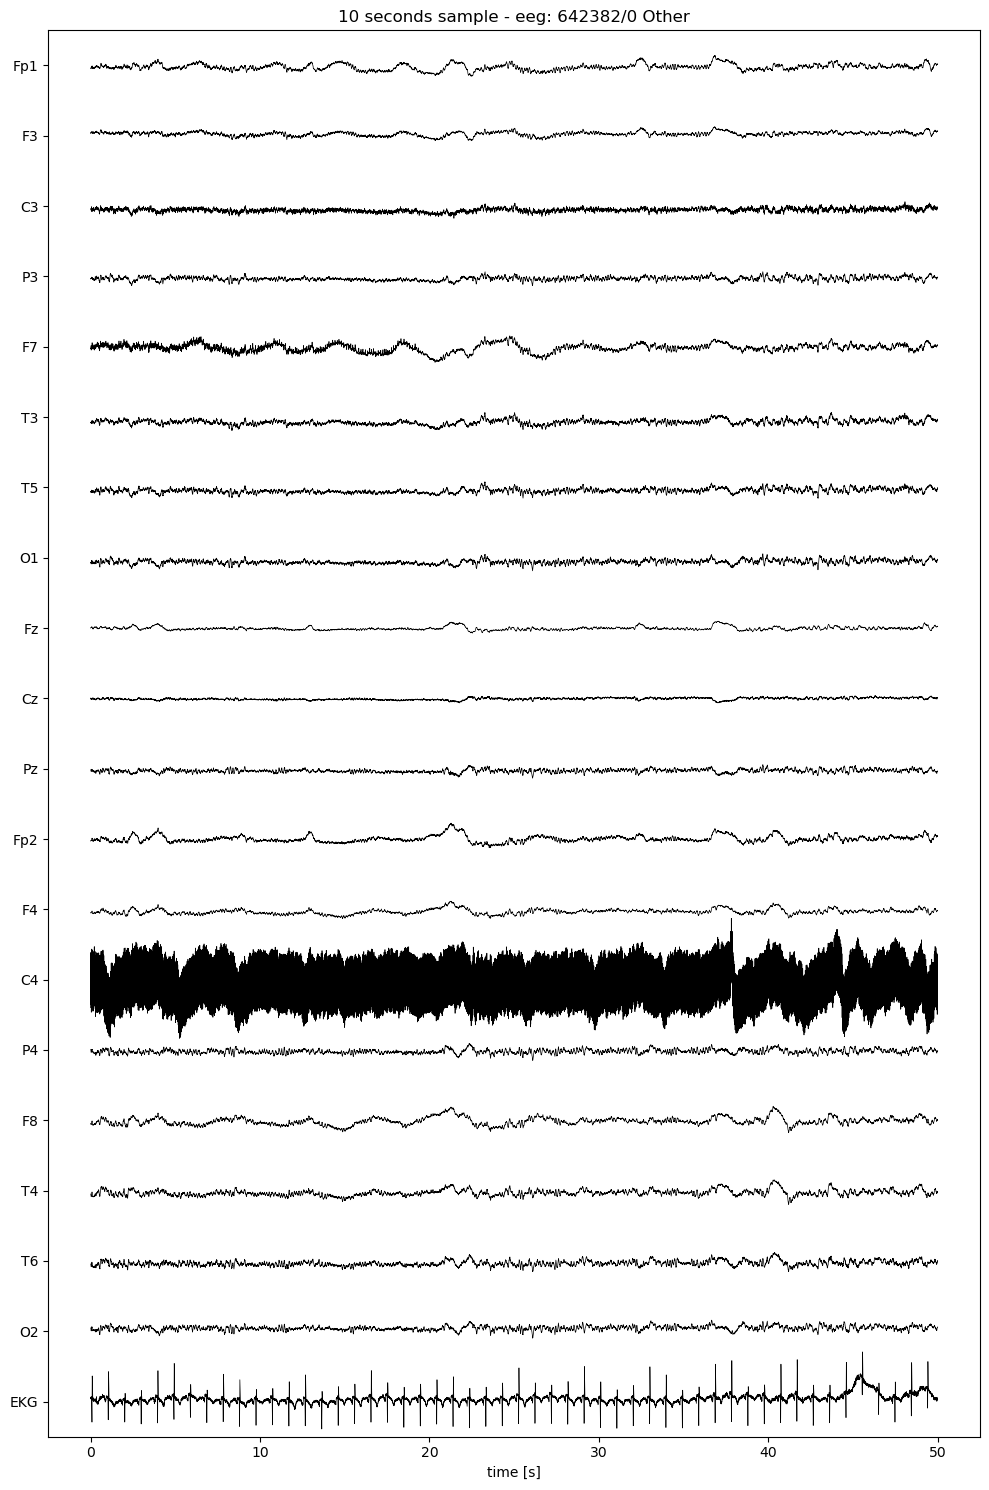

In [42]:
_df = df_9999.loc[df_9999.percentage_9999 > 0.2]
item = _df.iloc[0]
percentage = item.percentage_9999
eeg = pd.read_parquet(f'{base_dir}/train_eegs/{int(item.eeg_id)}.parquet')
item = df.loc[(df.eeg_id == item.eeg_id) & (df.eeg_sub_id == item.eeg_sub_id)].iloc[0]
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_sub_50 = eeg[start:end]
fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plot_eeg(ax, eeg_sub_50, title='10 seconds sample - eeg: ' + str(item.eeg_id)
          + '/' + str(item.eeg_sub_id) + ' ' + item.expert_consensus, sep = 500)

plt.tight_layout()
plt.show()

In [40]:
eeg_sub_50.map(lambda x: x == 9999.0).sum().sum()/size


0.0

## Counting votes in observations inside each eeg

Does the number of votes change for different offsets in the same eeg?

In [31]:
# Removing observations where eeg has more than 2 NaN rows.
idxs = np.load("../data/02_eegs_sub_50_idxs_less_3_nan.npy")
df = df_traincsv.loc[idxs]
print("Number of observations with less than 3 NaN rows:",len(df))

eeg_ids = df['eeg_id'].unique()
print("Number of eegs:", len(eeg_ids))

Number of observations with less than 3 NaN rows: 106556
Number of eegs: 17010


In [32]:
# Transform votes into percentages.
df['sum_votes'] = df.seizure_vote + df.lpd_vote + df.gpd_vote	+ df.lrda_vote + df.grda_vote + df.other_vote
df['seizure_vote'] = df.seizure_vote/df.sum_votes
df['lpd_vote'] = df.lpd_vote/df.sum_votes
df['gpd_vote'] = df.gpd_vote/df.sum_votes
df['lrda_vote'] = df.lrda_vote/df.sum_votes
df['grda_vote'] = df.grda_vote/df.sum_votes
df['other_vote'] = df.other_vote/df.sum_votes

In [53]:
cols = df.columns[-7:-1]
counts = []
for eeg_id in eeg_ids:
    counts.append(len(df.loc[df['eeg_id'] == eeg_id, cols].drop_duplicates()))
df_different_votes = pd.DataFrame({'eeg_id':eeg_ids,'changes':counts})
df_different_votes


,eeg_id,changes
0,1628180742,1
1,2277392603,1
2,722738444,1
3,387987538,1
4,2175806584,1
...,...,...
17005,3910994355,1
17006,3938393892,1
17007,1850739625,1
17008,1306668185,1


In [56]:
df_different_votes.loc[df_different_votes['changes'] > 1]

,eeg_id,changes
12,2578018731,2
36,531742289,2
42,3429523414,2
73,253736139,2
84,3636015289,3
...,...,...
16932,2024173188,2
16973,2838358862,2
16975,2293242511,2
16985,3588723605,7


The voting probabilities at different offsets change for 1549 eegs. 

<div class="alert alert-block alert-info">&rdsh; 1549 eegs have changes in votes percentages.</div>

In [71]:
eeg_ids_constant_votes = df_different_votes.loc[df_different_votes['changes'] == 1, 'eeg_id'].values
# np.save('../data/02_eeg_ids_constant_votes.npy',eeg_ids_constant_votes)
idxs = np.array([], dtype=int)
for eeg_id in eeg_ids_constant_votes:
    idxs = np.concatenate([idxs, df.loc[df['eeg_id'] == eeg_id].index.values])
print("Observations where all sub eegs have the same voting probs.:", len(idxs))
np.save("../data/02_idx_constant_votes.npy", idxs)  # Already discarded more than 2 NaN rows.

Observations where all sub eegs have the same voting probs.: 83893


## Overlapping (to be redone)

In [21]:
# Only eegs with 5 or less NaN rows.
idxs_wo_nan = np.load("../data/02_eegs_idxs_up_to_5_nan.npy")
df = df_traincsv.iloc[idxs_wo_nan]
print("Number of observations with 5 or less NaN rows:",len(df))


Number of observations with 5 or less NaN rows: 106358


In [22]:
_df = df.groupby(by=['eeg_id', 'expert_consensus'], as_index=False).size()
__df = _df.groupby(by=['eeg_id'], as_index=False).size()
__df.loc[__df['size'] > 1]

,eeg_id,size
80,21379701,3
122,32067830,2
137,36718960,2
144,37347312,2
161,42319244,2
...,...,...
16890,4268492759,2
16921,4279656286,2
16933,4282888597,2
16936,4283246598,2


<div class="alert alert-block alert-info">&rdsh; Only 779 eegs contain different targets. Most eegs have only one target.</div>

In [23]:
# eeg_id = 1029863597
# eeg_sub_id = 15  # seizure
eeg_id = 3988090520
# eeg_sub_id = 1

eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
items = df.loc[df.eeg_id == eeg_id]
idxs = items.index
items

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106049,3988090520,0,0.0,2127737134,0,0.0,1776227382,39994,Seizure,3,0,0,0,0,0
106050,3988090520,1,6.0,2127737134,1,6.0,579960926,39994,Seizure,3,0,0,0,0,0
106051,3988090520,2,8.0,2127737134,2,8.0,3241583494,39994,Seizure,3,0,0,0,0,0
106052,3988090520,3,18.0,2127737134,3,18.0,675726519,39994,Seizure,3,0,0,0,0,0
106053,3988090520,4,28.0,2127737134,4,28.0,458743039,39994,Seizure,3,0,0,0,0,0
106054,3988090520,5,32.0,2127737134,5,32.0,3111518914,39994,Seizure,3,0,0,0,0,0
106055,3988090520,6,34.0,2127737134,6,34.0,2970130228,39994,Seizure,3,0,0,0,0,0


In [24]:
items.loc[idxs[1]]

eeg_id                              3988090520
eeg_sub_id                                   1
eeg_label_offset_seconds                   6.0
spectrogram_id                      2127737134
spectrogram_sub_id                           1
spectrogram_label_offset_seconds           6.0
label_id                             579960926
patient_id                               39994
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 106050, dtype: object

In [25]:
def plot_eeg(ax, eeg, offsets, title, sep):
    # eeg is only one channel (or electrode)
    fs = 200 # Sample rate.
    # nx = eeg.shape[0]
    nx = int(10 * fs)
    totaltime = nx/fs
    X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
    # yticklabels = eeg.columns[::-1]  # Reversed.
    yticklabels = []

    for i, offset in enumerate(offsets):
        start = int((offset + 20) * fs)
        end = int((offset + 30) * fs)
        Y = eeg[start:end]
        yticklabels.append(f'{offset} seconds')
        ax.plot(X, Y + (i * sep), linewidth=0.5, color='black')

    ax.set_title(title)
    ax.set(ylim=(-0.5*sep, (len(yticklabels)-0.5)*sep),
           yticks=np.arange(len(yticklabels))*sep,
           yticklabels=yticklabels)
    ax.set_xlabel('time [s]')



Plot the events at the same electrode for different offsets inside the same eeg.

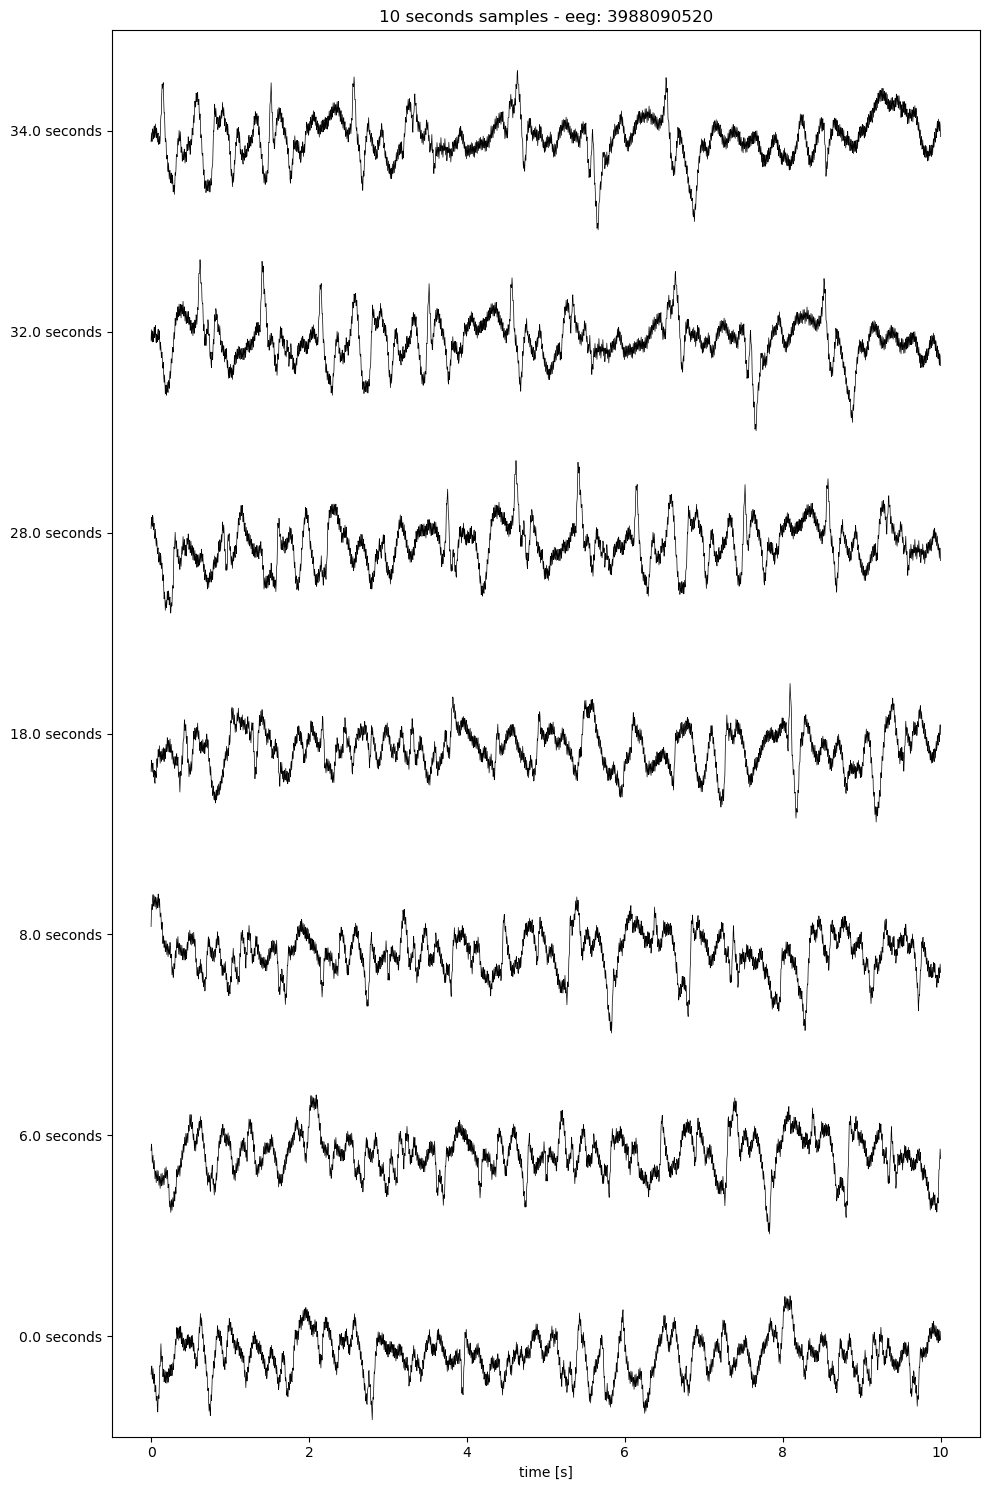

In [26]:
offsets = items['eeg_label_offset_seconds'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plot_eeg(ax, eeg['Fp1'], offsets, title='10 seconds samples - eeg: ' + str(eeg_id), sep = 200)

plt.tight_layout()
plt.show()

## Groups of overlapping eegs

<div>
    <image src="../images/eeg_groups.svg" width="1200">
</div>

Each sub eeg is 50 seconds length. Find gaps to separate groups: initial time is 50 seconds later than the previous initial time.

Determine if voting changes inside each group.

In [5]:
# Only eegs with 5 or less NaN rows.
idxs_wo_nan = np.load("../data/02_eegs_idxs_up_to_5_nan.npy")
df = df_traincsv.iloc[idxs_wo_nan]

In [6]:
df['sum_votes'] = df.seizure_vote + df.lpd_vote + df.gpd_vote	+ df.lrda_vote + df.grda_vote + df.other_vote
df['seizure_vote'] = df.seizure_vote/df.sum_votes
df['lpd_vote'] = df.lpd_vote/df.sum_votes
df['gpd_vote'] = df.gpd_vote/df.sum_votes
df['lrda_vote'] = df.lrda_vote/df.sum_votes
df['grda_vote'] = df.grda_vote/df.sum_votes
df['other_vote'] = df.other_vote/df.sum_votes

/tmp/ipykernel_5699/2584527904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sum_votes'] = df.seizure_vote + df.lpd_vote + df.gpd_vote	+ df.lrda_vote + df.grda_vote + df.other_vote
/tmp/ipykernel_5699/2584527904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seizure_vote'] = df.seizure_vote/df.sum_votes
/tmp/ipykernel_5699/2584527904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [7]:
overlap_limit = 50.0
d = {
    'eeg_id' : '',
    'eeg_sub_ids' : [],
    'group'  : '',
    't_initial' : '',
    't_final'   : '',  # 50 s after the last offset
    'votes'     :[]
}
df_groups = pd.DataFrame(data=d)

eeg_ids = np.unique(df['eeg_id'])

for eeg_id in eeg_ids:
    # eeg_id = 1029863597
    # eeg_sub_id = 15  # seizure
    # eeg_id = 3988090520
    # eeg_sub_id = 1

    items = df.loc[df.eeg_id == eeg_id].sort_values(by='eeg_label_offset_seconds')
    offsets = items['eeg_label_offset_seconds'].values
    ti = np.min(offsets)
    t_initial = ti

    idxs = items.index
    sub_ids = []
    group = 0
    votes = []
    for idx in idxs:
        item = items.loc[idx]
        new_ti = item.eeg_label_offset_seconds
        if  new_ti >= (ti + overlap_limit):
            d = {
                'eeg_id' : eeg_id,
                'eeg_sub_ids' : [sub_ids],
                'group'  : group,
                't_initial' : t_initial,
                't_final'   : t_final,  # 50 s after the last offset
                'votes'     : [np.unique(votes, axis=0)]
            }
            df_groups = pd.concat([df_groups, pd.DataFrame(data=d)], ignore_index=True)
            group = group + 1
            ti = new_ti
            t_initial = ti
            sub_ids = []
            sub_ids.append(item.eeg_sub_id)
            votes = []
            votes.append([item.seizure_vote, item.lpd_vote, item.gpd_vote, item.lrda_vote, item.grda_vote, item.other_vote])
            t_final = ti + overlap_limit
        else:
            ti = new_ti
            sub_ids.append(item.eeg_sub_id)
            votes.append([item.seizure_vote, item.lpd_vote, item.gpd_vote, item.lrda_vote, item.grda_vote, item.other_vote])
            t_final = ti + overlap_limit
    d = {
        'eeg_id' : eeg_id,
        'eeg_sub_ids' : [sub_ids],
        'group'  : group,
        't_initial' : t_initial,
        't_final'   : t_final,  # 50 s after the last offset
        'votes'     : [np.unique(votes, axis=0)]
    }
    df_groups = pd.concat([df_groups, pd.DataFrame(data=d)], ignore_index=True)      
    
df_groups

/tmp/ipykernel_5699/3704602253.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_groups = pd.concat([df_groups, pd.DataFrame(data=d)], ignore_index=True)


,eeg_id,eeg_sub_ids,group,t_initial,t_final,votes
0,568657,"[0, 1, 2, 3]",0,0.0,66.0,"[[0.0, 0.0, 0.25, 0.0, 0.16666666666666666, 0...."
1,582999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,0.0,88.0,"[[0.0, 0.8571428571428571, 0.0, 0.071428571428..."
2,642382,"[0, 1]",0,0.0,74.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]"
3,751790,[0],0,0.0,50.0,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]]"
4,778705,[0],0,0.0,50.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]"
...,...,...,...,...,...,...
16972,4293354003,[0],0,0.0,50.0,"[[0.0, 0.0, 0.0, 0.0, 0.5, 0.5]]"
16973,4293843368,[0],0,0.0,50.0,"[[0.0, 0.0, 0.0, 0.0, 0.5, 0.5]]"
16974,4294455489,[0],0,0.0,50.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]"
16975,4294858825,"[0, 1, 2, 3, 4]",0,0.0,62.0,"[[0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.9..."


In [8]:
df_groups.loc[df_groups.group > 0]

,eeg_id,eeg_sub_ids,group,t_initial,t_final,votes


<div class="alert alert-block alert-info">&rdsh; There are no gaps between sub eegs.</div>


In [9]:
df_groups.loc[df_groups.t_initial > 0]

,eeg_id,eeg_sub_ids,group,t_initial,t_final,votes


All eegs start at t=0 for the first offset.

In [10]:
np.max(df_groups.t_final)

3422.0

(array([13878.,  2546.,   361.,    85.,    39.,    68.]),
 array([   0.,  100.,  200.,  300.,  400.,  500., 3600.]),
 <BarContainer object of 6 artists>)

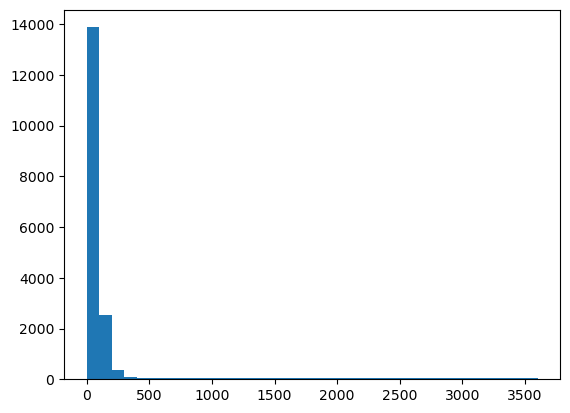

In [11]:
plt.hist(df_groups.t_final, bins=[0,100,200,300,400,500,3600])

In [12]:
df_groups[df_groups.votes.map(len) > 1]

,eeg_id,eeg_sub_ids,group,t_initial,t_final,votes
46,11127485,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",0,0.0,108.0,"[[0.8, 0.0, 0.2, 0.0, 0.0, 0.0], [1.0, 0.0, 0...."
72,19239792,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0,0.0,162.0,"[[0.8, 0.0, 0.0, 0.0, 0.0, 0.2], [1.0, 0.0, 0...."
76,20299905,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.0,324.0,"[[0.6, 0.2, 0.0, 0.0, 0.0, 0.2], [1.0, 0.0, 0...."
80,21379701,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.0,208.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.75, 0..."
122,32067830,"[0, 1, 2, 3, 4]",0,0.0,130.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.5, 0...."
...,...,...,...,...,...,...
16921,4279656286,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.0,124.0,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.3333333333..."
16933,4282888597,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.0,156.0,"[[0.2727272727272727, 0.0, 0.0, 0.727272727272..."
16936,4283246598,"[0, 1, 2]",0,0.0,56.0,"[[0.0, 0.1875, 0.0625, 0.0, 0.4375, 0.3125], [..."
16945,4284659653,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.0,238.0,"[[0.0, 0.0, 0.0, 0.0, 0.25, 0.75], [0.0, 0.0, ..."


In [58]:
df_groups.loc[16933].votes

array([[0.27272727, 0.        , 0.        , 0.72727273, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

<div class="alert alert-block alert-info">&rdsh; 1545 out of 16977 eegs have changes in votes percentages.</div>


## Different percentages in votes

Possible classes.

In [13]:
vs = df_groups.loc[df_groups.votes.map(len) == 1].votes
all_votes = np.array([]).reshape(0,6)
for v in vs:
    all_votes = np.concatenate([all_votes, v[0].reshape(1,6)])
np.unique(all_votes, axis=0).shape


(2351, 6)

2351 different combinations of percentages in votes. Too many possible classes.

## Unanimous consensus

In the list of eegs that have one type of vote.

In [15]:
eeg_ids = df_groups.loc[df_groups.votes.map(len) == 1].eeg_id.values
eeg_ids

array([568657, 582999, 642382, ..., 4294455489, 4294858825, 4294958358],
      dtype=object)

In [16]:
df.loc[:,'dummy_seizure'] = 0
df.loc[df.seizure_vote > 0, 'dummy_seizure'] = 1
df.loc[:,'dummy_lpd'] = 0
df.loc[df.lpd_vote > 0, 'dummy_lpd'] = 1
df.loc[:,'dummy_gpd'] = 0
df.loc[df.gpd_vote > 0, 'dummy_gpd'] = 1
df.loc[:,'dummy_lrda'] = 0
df.loc[df.lrda_vote > 0, 'dummy_lrda'] = 1
df.loc[:,'dummy_grda'] = 0
df.loc[df.grda_vote > 0, 'dummy_grda'] = 1
df.loc[:,'dummy_other'] = 0
df.loc[df.other_vote > 0, 'dummy_other'] = 1
df['sum_votes'] = df.dummy_seizure + df.dummy_lpd + df.dummy_gpd + df.dummy_lrda + df.dummy_grda + df.dummy_other
df

/tmp/ipykernel_5699/1900860189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'dummy_seizure'] = 0
/tmp/ipykernel_5699/1900860189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'dummy_lpd'] = 0
/tmp/ipykernel_5699/1900860189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,sum_votes,dummy_seizure,dummy_lpd,dummy_gpd,dummy_lrda,dummy_grda,dummy_other
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,...,0.0,0.0,0.0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0.0,...,1.0,0.0,0.0,1,0,0,0,1,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0.0,...,1.0,0.0,0.0,1,0,0,0,1,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0.0,...,1.0,0.0,0.0,1,0,0,0,1,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0.0,...,1.0,0.0,0.0,1,0,0,0,1,0,0


In [33]:
ids = np.array([],dtype=int)
for eeg_id in eeg_ids:
    if df.loc[df.eeg_id==eeg_id].sum_votes.values[0] == 1:
        ids = np.append(ids, eeg_id)
ids
    

array([    642382,     751790,     778705, ..., 4293144208, 4294455489,
       4294958358])

In [34]:
len(ids)

9051

In [35]:
# Ids of eegs where:
# 5 or less NaN rows (to interpolate).
# No change of votes in the different sub eegs.
# There is unanimous consensus.
#
np.save("../data/02_eegs_ids_unanimous_and_single_class.npy", ids)

In [43]:
vote = np.array([])
for eeg_id in ids:
    vote = np.append(vote, df.loc[df.eeg_id==eeg_id]['expert_consensus'].values[0])
df_vote = pd.DataFrame(vote)
df_vote

,0
0,Other
1,GPD
2,Other
3,Seizure
4,Other
...,...
9046,Other
9047,Seizure
9048,Other
9049,Other


In [47]:
_df = df_vote.groupby(by=0, as_index=False).size()
total = len(df_vote)
_df['percentage'] = _df['size']/total
_df

,0,size,percentage
0,GPD,750,0.082864
1,GRDA,1121,0.123854
2,LPD,1052,0.116230
3,LRDA,364,0.040217
4,Other,4089,0.451773
5,Seizure,1675,0.185062


Imbalance is high. Perhaps a subsampling of 'Other' would be convenient.